# XGBoost Model
Preprocessing Steps:
1. Convert valid time into datetime data types
2. sort values by city and valid time
3. multiply pm2.5 with 1e07
4. scale the dataset using minmax scaler
5. extract time variables from the dataset
6. encode the city column
7. Create Lagged Variables

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import shap
import joblib
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Research Methodology/Dataset and Training File/All_Cities_AirQuality_Climate_Data - XGBoost.csv")

In [ ]:
df['valid_time'] = pd.to_datetime(df['valid_time'])
df = df.sort_values(['city', 'valid_time'])

In [ ]:
df['pm2p5'] *= 1e07
df = df.drop(columns=['pm1', 'pm10'], axis = 1)

In [ ]:
df['hour'] = df['valid_time'].dt.hour
df['days'] = df['valid_time'].dt.dayofweek
df['month'] = df['valid_time'].dt.month

In [ ]:
lags = [1, 2, 3, 6, 12]
for col in ['pm2p5', 't2m', 'blh']:
  for lag in lags:
    df[f"{col}_lag{lag}"] = df.groupby('city')[col].shift(lag)
df = df.dropna()

In [ ]:
df = pd.get_dummies(df, columns=['city'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10740 entries, 12 to 10775
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   valid_time     10740 non-null  datetime64[ns]
 1   bcaod550       10740 non-null  float64       
 2   omaod550       10740 non-null  float64       
 3   pm2p5          10740 non-null  float64       
 4   aod550         10740 non-null  float64       
 5   tcco           10740 non-null  float64       
 6   tcno2          10740 non-null  float64       
 7   gtco3          10740 non-null  float64       
 8   tcso2          10740 non-null  float64       
 9   u10            10740 non-null  float64       
 10  v10            10740 non-null  float64       
 11  d2m            10740 non-null  float64       
 12  t2m            10740 non-null  float64       
 13  sp             10740 non-null  float64       
 14  blh            10740 non-null  float64       
 15  tp             10740 no

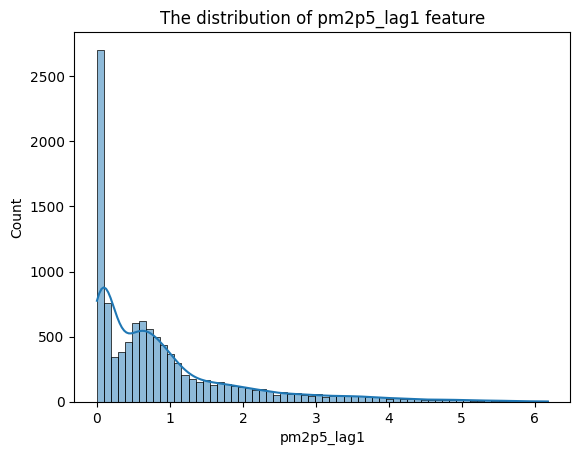

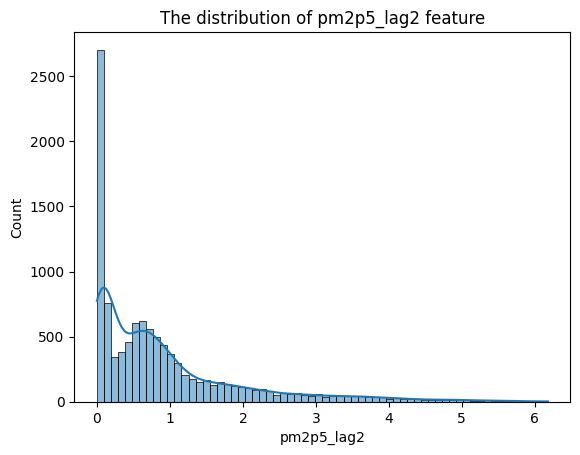

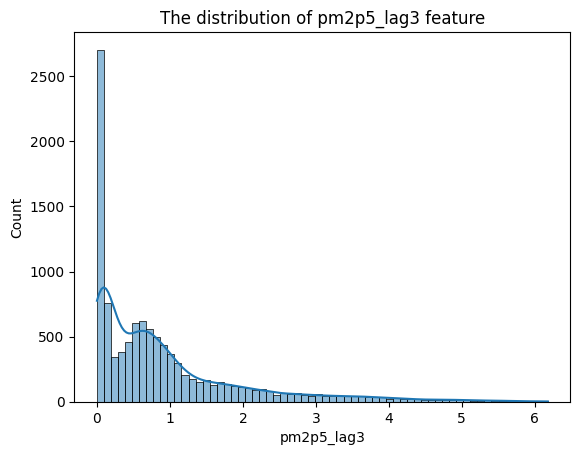

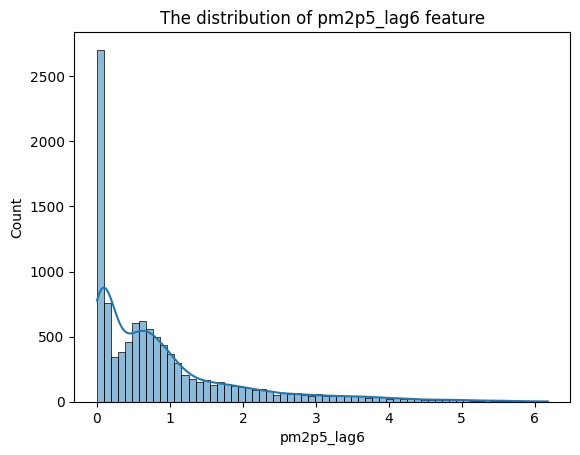

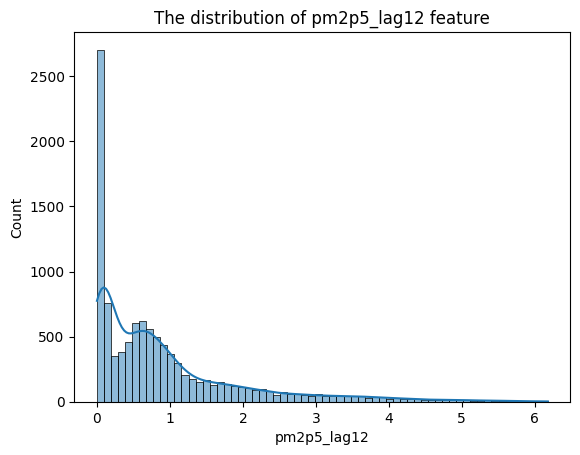

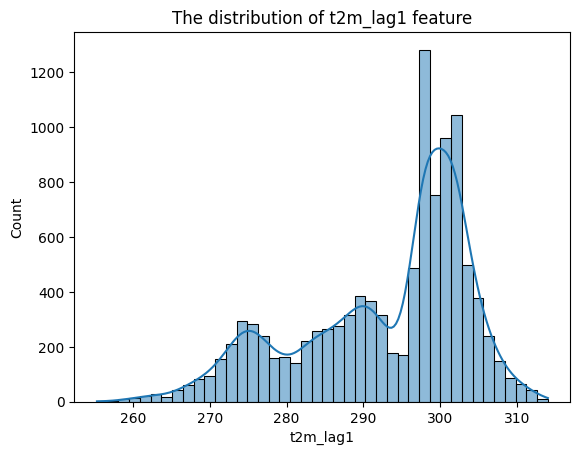

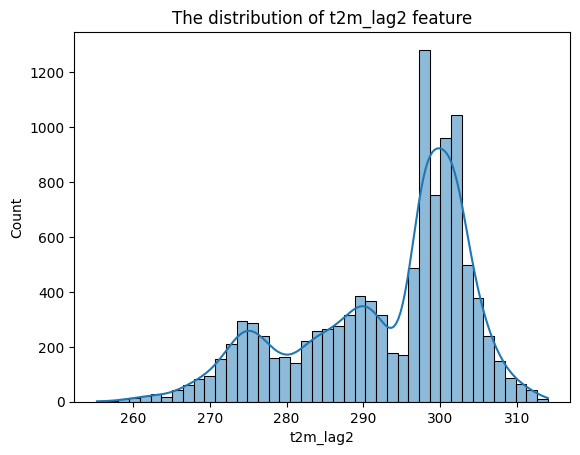

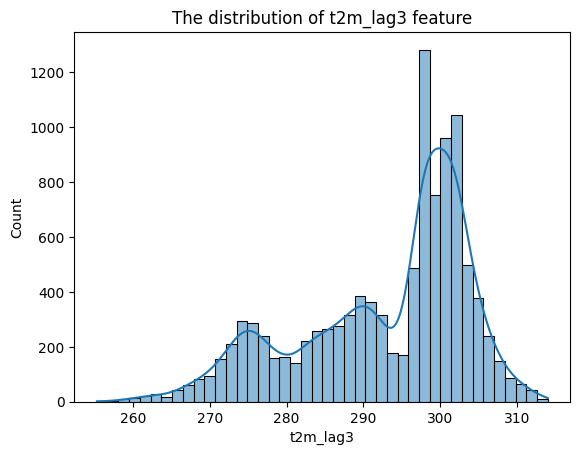

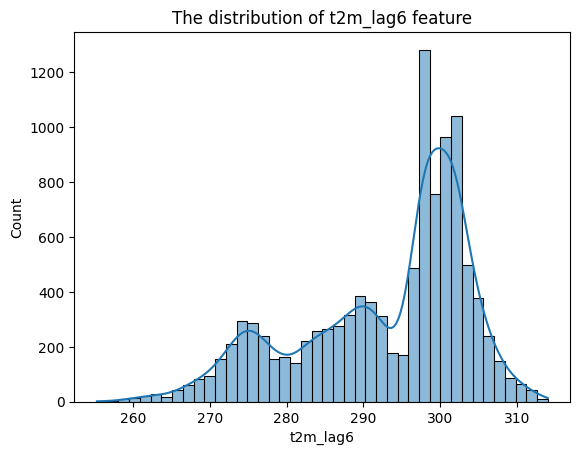

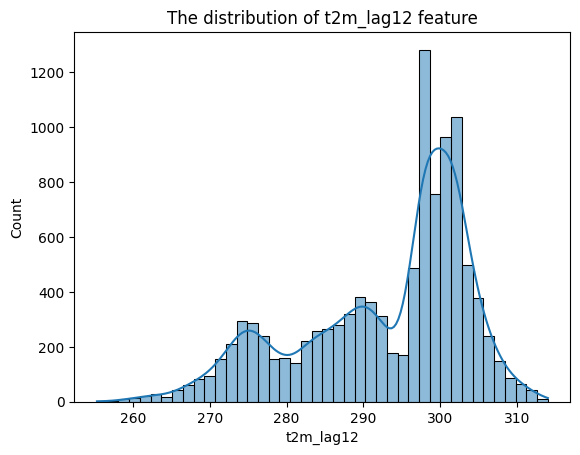

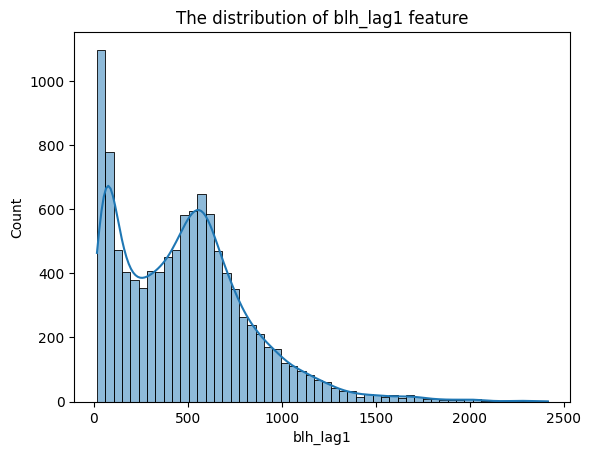

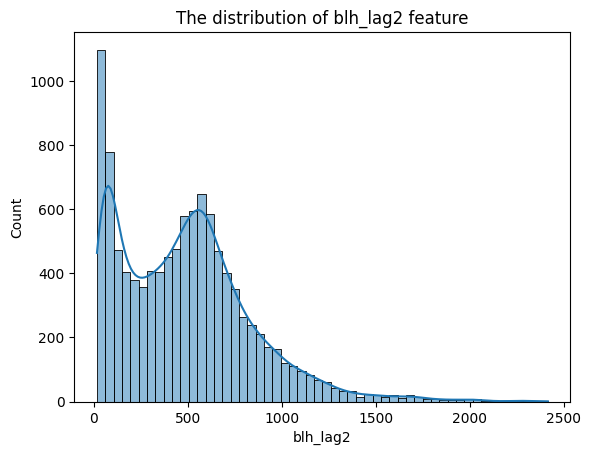

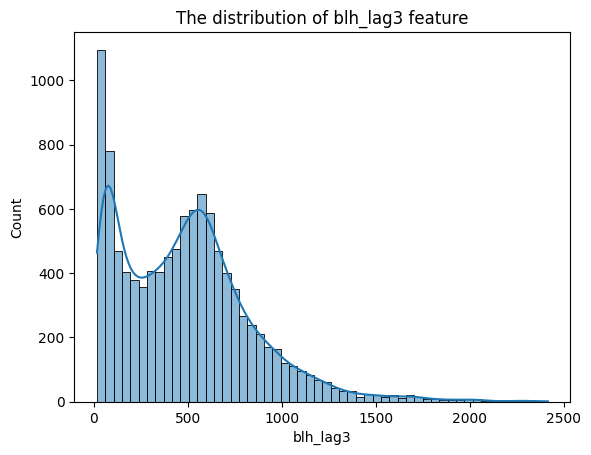

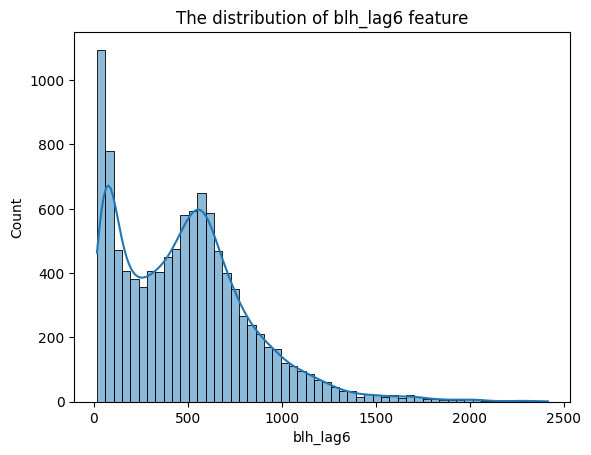

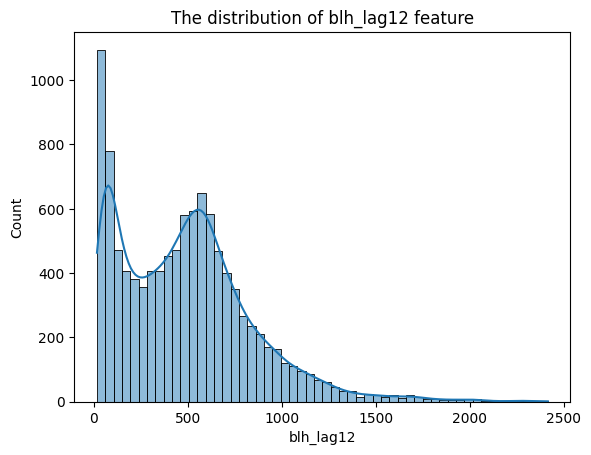

In [ ]:
for col in ['pm2p5_lag1', 'pm2p5_lag2', 'pm2p5_lag3', 'pm2p5_lag6', 'pm2p5_lag12', 't2m_lag1', 't2m_lag2', 't2m_lag3', 't2m_lag6', 't2m_lag12', 'blh_lag1', 'blh_lag2', 'blh_lag3', 'blh_lag6', 'blh_lag12']:
  sns.histplot(df[col], kde=True)
  plt.title(f"The distribution of {col} feature")
  plt.show()

In [ ]:
data_corr = df.corr(method='pearson')
correlation = data_corr['pm2p5'].sort_values(ascending=False)
correlation

,pm2p5
pm2p5,1.000000
pm2p5_lag2,0.908278
pm2p5_lag1,0.867760
pm2p5_lag6,0.851205
pm2p5_lag12,0.833226
pm2p5_lag3,0.805414
tcso2,0.768333
tcco,0.740091
city_Delhi,0.738460
bcaod550,0.721129


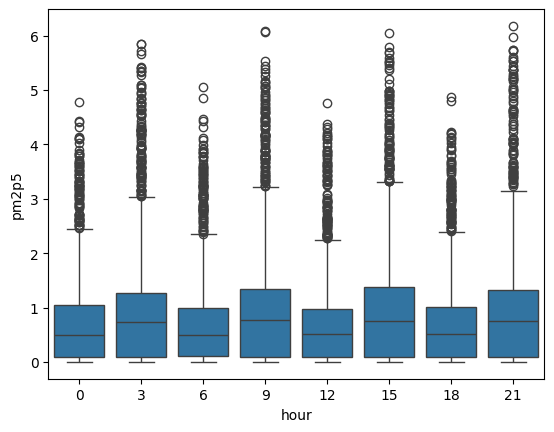

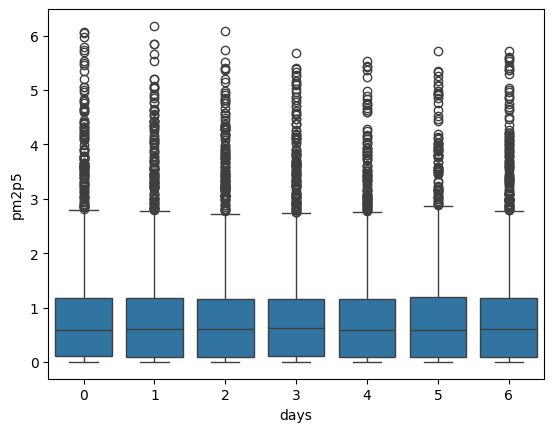

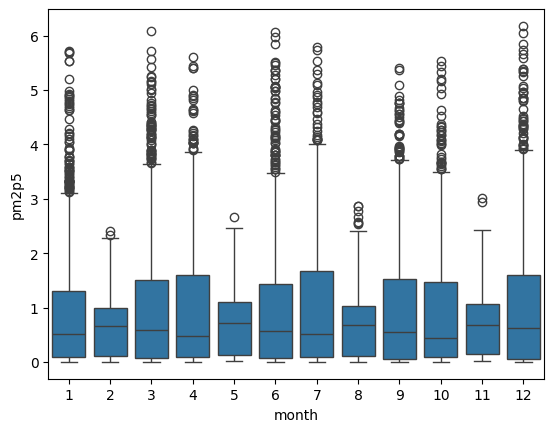

In [ ]:
for col in ['hour', 'days', 'month']:
  sns.boxplot(x=col, y='pm2p5', data=df)
  plt.show()

In [ ]:
X = df.drop(columns=['valid_time', 'pm2p5'])
y = df['pm2p5']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
minmax_x = MinMaxScaler()
minmax_y = MinMaxScaler()

X_train_minmax = minmax_x.fit_transform(X_train)
X_test_minmax = minmax_x.transform(X_test)

y_train_minmax = minmax_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_minmax = minmax_y.transform(y_test.values.reshape(-1, 1))

In [ ]:
xgb_base = XGBRegressor()

In [ ]:
xgb_base.fit(X_train_minmax, y_train_minmax)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred_base = xgb_base.predict(X_test_minmax)

In [ ]:
y_pred_inverse = minmax_y.inverse_transform(y_pred_base.reshape(-1, 1))
y_test_inverse = minmax_y.inverse_transform(y_test_minmax.reshape(-1, 1))

In [ ]:
print(f"Base XGBoost Model RMSE Score: {root_mean_squared_error(y_test_inverse, y_pred_inverse)}")
print(f"Base XGBoost Model MAE Score: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"Base XGBoost R2 Score: {r2_score(y_test_inverse, y_pred_inverse)}")

Base XGBoost Model RMSE Score: 0.2308190405138794
Base XGBoost Model MAE Score: 0.12738167987143117
Base XGBoost R2 Score: 0.9524439929532508


In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators': [50, 100, 200, 300],
}

grid_search = GridSearchCV(XGBRegressor(), param_grid,  scoring={ 'rmse': 'neg_root_mean_squared_error', 'mae': 'neg_mean_absolute_error', 'r2': 'r2'}, refit='rmse', cv=5)
grid_search.fit(X_train_minmax, y_train_minmax)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200, 300]},
             refit='rmse',
             scoring={'mae': 'neg_mean_absolute_error', 'r2': 'r2',
                      'rmse': 'neg_root_mean_squared_error'})

In [ ]:
xgb_bestParam = grid_search.best_params_
print(xgb_bestParam)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


In [ ]:
xgb_bestEstimator = grid_search.best_estimator_

In [ ]:
y_pred_grid_search = grid_search.predict(X_test_minmax)

In [ ]:
y_pred_gs_inverse = minmax_y.inverse_transform(y_pred_grid_search.reshape(-1, 1))

In [ ]:
print(f"Grid Search XGBoost Model RMSE Score: {root_mean_squared_error(y_test_inverse, y_pred_gs_inverse)}")
print(f"Grid Search XGBoost Model MAE Score: {mean_absolute_error(y_test_inverse, y_pred_gs_inverse)}")
print(f"Grid Search XGBoost R2 Score: {r2_score(y_test_inverse, y_pred_gs_inverse)}")

Grid Search XGBoost Model RMSE Score: 0.213949505468847
Grid Search XGBoost Model MAE Score: 0.11888146996347852
Grid Search XGBoost R2 Score: 0.9591412859506665


In [ ]:
y_train_pred = grid_search.predict(X_train_minmax)
y_test_pred = grid_search.predict(X_test_minmax)

y_train_inverse = minmax_y.inverse_transform(y_train_minmax)

y_train_pred_inv = minmax_y.inverse_transform(y_train_pred.reshape(-1, 1))
y_test_pred_inv = minmax_y.inverse_transform(y_test_pred.reshape(-1, 1))

print("Grid Search Result")
print(f"Training Data RMSE Score: {root_mean_squared_error(y_train_pred_inv, y_train_inverse)}")
print(f"Training Data MAE Score: {mean_absolute_error(y_train_pred_inv, y_train_inverse)}")
print(f"Training Data R2 Score: {r2_score(y_train_pred_inv, y_train_inverse)}")
print(f"Training Data MAPE Score: {mean_absolute_percentage_error(y_train_pred_inv, y_train_inverse)}")
print()
print(f"Testing Data RMSE Score: {root_mean_squared_error(y_test_pred_inv, y_test_inverse)}")
print(f"Testing Data MAE Score: {mean_absolute_error(y_test_pred_inv, y_test_inverse)}")
print(f"Testing Data R2 Score: {r2_score(y_test_pred_inv, y_test_inverse)}")
print(f"Testing Data MAPE Score: {mean_absolute_percentage_error(y_test_pred_inv, y_test_inverse)}")

Grid Search Result
Training Data RMSE Score: 0.0757314342170497
Training Data MAE Score: 0.050749861547374986
Training Data R2 Score: 0.9946492092232094
Training Data MAPE Score: 0.143929885989765

Testing Data RMSE Score: 0.213949505468847
Testing Data MAE Score: 0.11888146996347852
Testing Data R2 Score: 0.9566030090034234
Testing Data MAPE Score: 0.19235253745116182


In [ ]:
importances = xgb_bestEstimator.feature_importances_

feature_names = X.columns

feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values('Importance', ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(10))
plt.tight_layout()
plt.savefig("XGBoost_feature_importance.png", dpi=300, bbox_inches='tight')
plt.close()

from google.colab import files
files.download("XGBoost_feature_importance.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
joblib.dump(xgb_base, "Base_Scaled_XGBoost_Air_Quality_Model.pkl")
joblib.dump(grid_search.best_estimator_, "GridSearch_Scaled_XGBoost_Air_Quality_Model.pkl")

['GridSearch_Scaled_XGBoost_Air_Quality_Model.pkl']